<a href="https://colab.research.google.com/github/pockerman/hidden_markov_modeling/blob/master/stories/story_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Story 58


Chromosome 18


Apply ```HMM_Model_9.json``` in regions: 

* [R1: ```region_0_REGION_1_CHR_18_MEAN_CUTOFF.txt```,  1000000-15000000](#r1)
* [R2: ```region_0_REGION_2_CHR_18_MEAN_CUTOFF.txt```,  22000000-42000000](#r2) 
* [R3: ```region_0_REGION_3_CHR_18_MEAN_CUTOFF.txt```,  42000000-62000000](#r3)
* [R4: ```region_0_REGION_4_CHR_18_MEAN_CUTOFF.txt```,  62000000-72000000](#r4)


In [1]:
import sys
sys.path.append("../")

In [2]:
import numpy as np
from pomegranate import *
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from helpers import read_configuration_file, INFO, WARNING
from hmm_helpers import build_hmm
from helpers import WindowType
from preprocess_utils import get_distributions_list_from_names as get_dist_list
from region import Region

In [4]:
from notebooks_helpers import filter_viterbi_path
from notebooks_helpers import save_segments
from notebooks_helpers import load_data_file
from notebooks_helpers import get_start_end_segment
from notebooks_helpers import make_data_array
from notebooks_helpers import gmm_clustering
from notebooks_helpers import create_viterbi_path
from notebooks_helpers import create_states
from notebooks_helpers import create_tuf_state
from notebooks_helpers import get_states_counter
from notebooks_helpers import plot_hmm_states_to_labels
from notebooks_helpers import plot_hmm_label_state
from notebooks_helpers import plot_hmm_cluster_contours

In [5]:
sns.set(color_codes=True)

Orphan state HMM_Model-start removed due to no edges                             leading to it
Orphan state HMM_Model-end removed due to no edges                             leading to it


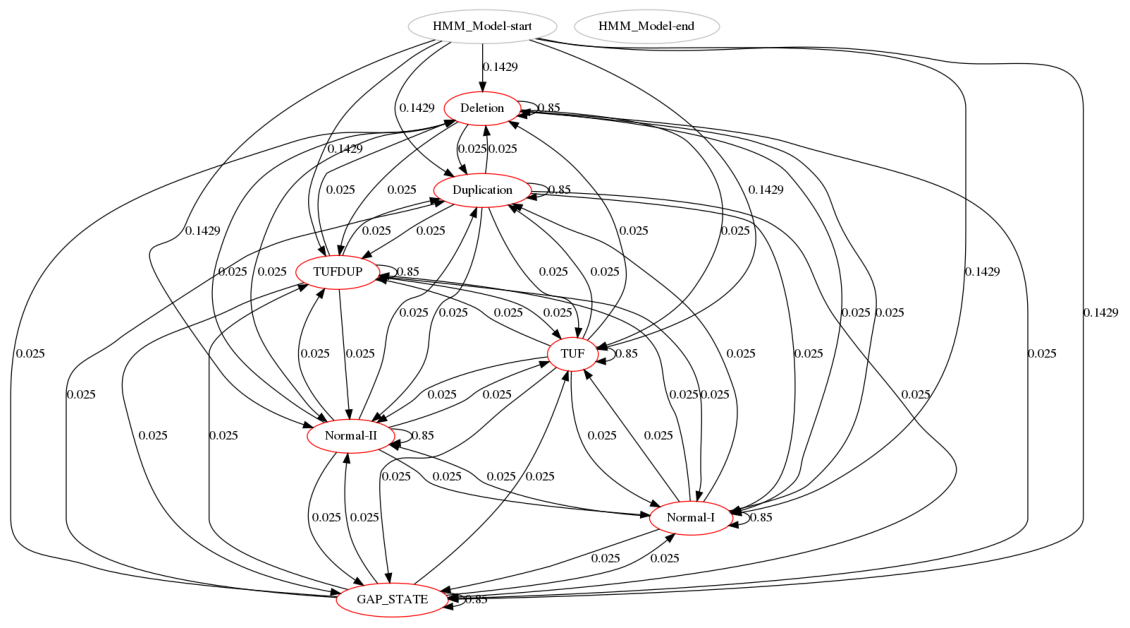

In [6]:
# load the configuration
configuration = read_configuration_file("../config.json")
hmm_config = configuration["HMM"]
hmm_filename = "HMM_Model_9.json"
hmm_model = build_hmm(hmm_file=hmm_filename)
# visualize the model we just trained
plt.figure( figsize=(20,18) )
hmm_model.plot()
plt.show()

## <a name="r1"></a>  Region 1

In [7]:
chr='chr18'
viterbi_paths = 'viterbi_paths_chr18/'


In [8]:
# load the region we want to use for prediction
region_name = "region_0_REGION_1_CHR_18_MEAN_CUTOFF.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_1_CHR_18_MEAN_CUTOFF.txt
Sequence length:  140000


In [9]:
filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths

filename = filename + "viterbi_path_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, 
                                                                         hmm_model=hmm_model,
                                                                         chr=chr,
                                                                         filename=filename)

Observation length:  140000
Done. Execution time 0.5338827369996579 secs
Log-probability of ML Viterbi path:  -934087.3842003928
Viterbi path length:  140001
There should be 0 gaps


In [10]:
# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths
filename = filename + "tuf_delete_tuf_" + region_name
save_segments(segments=segments, chromosome=chr, filename=filename)

Length of path  140000
Length of TUF+DELETION+TUF state:  153


In [11]:
wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

Length of WGA Observations:  140000
Encountered gaps:  0


In [13]:
states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0, 'TUFDUP':0}

states_counter, state_data = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 

{'Duplication': 97, 'Normal-I': 107863, 'Normal-II': 29931, 'Deletion': 61, 'Single-Deletion': 0, 'TUF': 2048, 'GAP_STATE': 0, 'GAP_STATE_INCORRECT': 0, 'TUFDUP': 0}


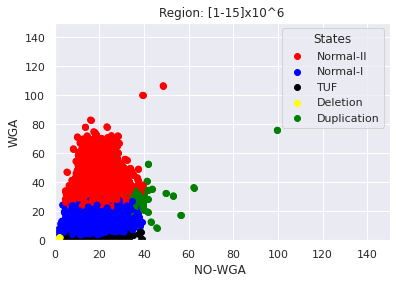

HMM labels color:  {'red': [2, 29931], 'blue': [1, 107863], 'black': [5, 2048], 'yellow': [3, 61], 'green': [0, 97]}


In [14]:
hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5, "TUFDUP":6}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = \
plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                          observations=observations, 
                          sequence_viterbi_state=sequence_viterbi_state, 
                          no_wga_obs=no_wga_obs, wga_obs=wga_obs,
                          title="Region: [1-15]x10^6",
                          xlim=(0.0, 150.), ylim=(0.0, 150.0))
print("HMM labels color: ", color_comp_assoc_hmm)

In [15]:
for state in state_data:
    print("State: ", state)
    
    if len(state_data[state][0]) == 0:
        continue
    
    print("WGA mean/var: ", np.mean(state_data[state][0]), np.var(state_data[state][0]))
    print("NO-WGA mean/var: ", np.mean(state_data[state][1]), np.var(state_data[state][1]))

State:  Duplication
WGA mean/var:  26.629381443298968 62.08724291635668
NO-WGA mean/var:  36.39670103092784 75.31404272505048
State:  Normal-I
WGA mean/var:  16.023486088834908 25.406386962729353
NO-WGA mean/var:  18.436419810314934 21.282956080751966
State:  Normal-II
WGA mean/var:  30.527329524573187 49.64288044665728
NO-WGA mean/var:  19.734604256456514 18.430785486198843
State:  Deletion
WGA mean/var:  1.692950819672131 1.7275289975812955
NO-WGA mean/var:  2.4777049180327873 1.8515389948938457
State:  Single-Deletion
State:  TUF
WGA mean/var:  2.2076318359375 2.322465436720848
NO-WGA mean/var:  15.9993115234375 26.832996742796897
State:  GAP_STATE
State:  GAP_STATE_INCORRECT
State:  TUFDUP


## <a name="r2"></a> Region 2

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_2_CHR_18_MEAN_CUTOFF.txt
Sequence length:  199989
Observation length:  199989
Done. Execution time 0.5236639079994347 secs
Log-probability of ML Viterbi path:  -1352907.776524234
Viterbi path length:  199990
There should be 0 gaps
Length of path  199989
Length of TUF+DELETION+TUF state:  96
Length of WGA Observations:  199989
Encountered gaps:  0
{'Duplication': 79, 'Normal-I': 149715, 'Normal-II': 49534, 'Deletion': 159, 'Single-Deletion': 0, 'TUF': 502, 'GAP_STATE': 0, 'GAP_STATE_INCORRECT': 0, 'TUFDUP': 0}


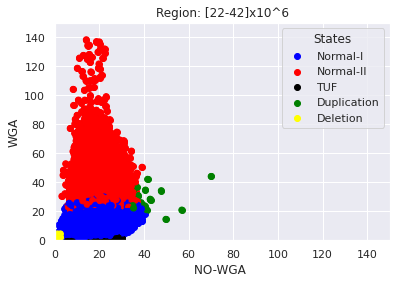

HMM labels color:  {'blue': [1, 149715], 'red': [2, 49534], 'black': [5, 502], 'green': [0, 79], 'yellow': [3, 159]}
State:  Duplication
WGA mean/var:  25.584430379746838 26.783594295785935
NO-WGA mean/var:  35.80569620253165 35.35101945201088
State:  Normal-I
WGA mean/var:  16.472940787496242 23.262159333601048
NO-WGA mean/var:  19.235703837290853 20.785071468511145
State:  Normal-II
WGA mean/var:  31.371845399119795 74.0464830583451
NO-WGA mean/var:  19.78227924254048 19.043461930664133
State:  Deletion
WGA mean/var:  0.9764779874213836 1.759827846999723
NO-WGA mean/var:  1.0739622641509434 1.8873547407143703
State:  Single-Deletion
State:  TUF
WGA mean/var:  2.883227091633466 2.0055238488277967
NO-WGA mean/var:  15.234143426294821 39.81465215472771
State:  GAP_STATE
State:  GAP_STATE_INCORRECT
State:  TUFDUP


In [16]:
# load the region we want to use for prediction
region_name = "region_0_REGION_2_CHR_18_MEAN_CUTOFF.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths

filename = filename + "viterbi_path_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, 
                                                                         hmm_model=hmm_model, 
                                                                         chr=chr,
                                                                         filename=filename)

# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths
filename = filename + "tuf_delete_tuf_" + region_name
save_segments(segments=segments, chromosome=chr, filename=filename)

wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0, 'TUFDUP':0}

states_counter, state_data = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 

hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5, "TUFDUP":6}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = \
plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                          observations=observations, 
                          sequence_viterbi_state=sequence_viterbi_state, 
                          no_wga_obs=no_wga_obs, wga_obs=wga_obs, 
                          title="Region: [22-42]x10^6",
                          xlim=(0.0, 150.), ylim=(0.0, 150.0))
print("HMM labels color: ", color_comp_assoc_hmm)

for state in state_data:
    print("State: ", state)
    
    if len(state_data[state][0]) == 0:
        continue
    
    print("WGA mean/var: ", np.mean(state_data[state][0]), np.var(state_data[state][0]))
    print("NO-WGA mean/var: ", np.mean(state_data[state][1]), np.var(state_data[state][1]))

## <a name="r3"></a>  Region 3

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_3_CHR_18_MEAN_CUTOFF.txt
Sequence length:  199995
Observation length:  199995
Done. Execution time 0.5452946969999175 secs
Log-probability of ML Viterbi path:  -1352272.056036096
Viterbi path length:  199996
There should be 512 gaps
Length of path  199995
Length of TUF+DELETION+TUF state:  204
Length of WGA Observations:  199483
Encountered gaps:  512
{'Duplication': 233, 'Normal-I': 144142, 'Normal-II': 54334, 'Deletion': 104, 'Single-Deletion': 0, 'TUF': 670, 'GAP_STATE': 512, 'GAP_STATE_INCORRECT': 0, 'TUFDUP': 0}


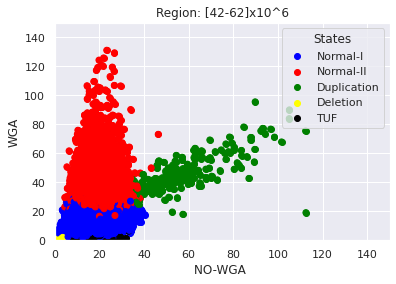

HMM labels color:  {'blue': [1, 144142], 'red': [2, 54334], 'green': [0, 233], 'yellow': [3, 104], 'black': [5, 670]}
State:  Duplication
WGA mean/var:  42.38579399141631 217.31673595756047
NO-WGA mean/var:  53.53815450643776 342.96714380445394
State:  Normal-I
WGA mean/var:  16.70097806329869 23.37280192666007
NO-WGA mean/var:  18.669482801681667 20.894583192566117
State:  Normal-II
WGA mean/var:  31.497630949313507 67.73559258762094
NO-WGA mean/var:  19.20518754371112 18.713963758216394
State:  Deletion
WGA mean/var:  1.1373076923076921 1.620494674556213
NO-WGA mean/var:  1.5832692307692307 1.8231200813609465
State:  Single-Deletion
State:  TUF
WGA mean/var:  2.898537313432836 2.274852188906215
NO-WGA mean/var:  14.914611940298508 26.74010873000668
State:  GAP_STATE
WGA mean/var:  -999.0 0.0
NO-WGA mean/var:  -999.0 0.0
State:  GAP_STATE_INCORRECT
State:  TUFDUP


In [17]:
# load the region we want to use for prediction
region_name = "region_0_REGION_3_CHR_18_MEAN_CUTOFF.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths

filename = filename + "viterbi_path_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, 
                                                                         hmm_model=hmm_model, 
                                                                         chr=chr,
                                                                         filename=filename)

# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths
filename = filename + "tuf_delete_tuf_" + region_name
save_segments(segments=segments, chromosome=chr, filename=filename)

wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0, 'TUFDUP':0}

states_counter, state_data = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 

hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5, "TUFDUP":6}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = \
plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                          observations=observations, 
                          sequence_viterbi_state=sequence_viterbi_state, 
                          no_wga_obs=no_wga_obs, wga_obs=wga_obs, 
                          title="Region: [42-62]x10^6",
                          xlim=(0.0, 150.), ylim=(0.0, 150.0))
print("HMM labels color: ", color_comp_assoc_hmm)

for state in state_data:
    print("State: ", state)
    
    if len(state_data[state][0]) == 0:
        continue
    
    print("WGA mean/var: ", np.mean(state_data[state][0]), np.var(state_data[state][0]))
    print("NO-WGA mean/var: ", np.mean(state_data[state][1]), np.var(state_data[state][1]))

## <a name="r4"></a>  Region 4

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_4_CHR_18_MEAN_CUTOFF.txt
Sequence length:  100000
Observation length:  100000
Done. Execution time 0.26734449499963375 secs
Log-probability of ML Viterbi path:  -662937.1757691633
Viterbi path length:  100001
There should be 0 gaps
Length of path  100000
Length of TUF+DELETION+TUF state:  66
Length of WGA Observations:  100000
Encountered gaps:  0
{'Duplication': 21, 'Normal-I': 84036, 'Normal-II': 15578, 'Deletion': 108, 'Single-Deletion': 0, 'TUF': 257, 'GAP_STATE': 0, 'GAP_STATE_INCORRECT': 0, 'TUFDUP': 0}


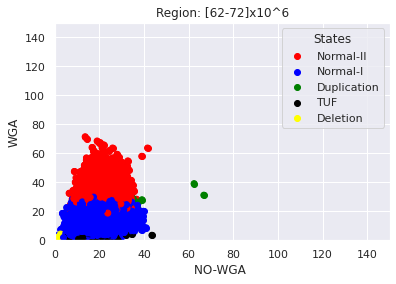

HMM labels color:  {'red': [2, 15578], 'blue': [1, 84036], 'green': [0, 21], 'black': [5, 257], 'yellow': [3, 108]}
State:  Duplication
WGA mean/var:  25.271428571428572 27.01488843537415
NO-WGA mean/var:  36.986666666666665 88.90475555555555
State:  Normal-I
WGA mean/var:  15.704915750392686 23.341092485405216
NO-WGA mean/var:  19.81477224046837 21.459428686999416
State:  Normal-II
WGA mean/var:  29.585357555527022 35.5906965630001
NO-WGA mean/var:  20.55733149313134 18.505965462201146
State:  Deletion
WGA mean/var:  0.3211111111111111 0.6624950617283949
NO-WGA mean/var:  0.42416666666666664 0.9489520833333331
State:  Single-Deletion
State:  TUF
WGA mean/var:  2.852451361867704 1.8197554694242155
NO-WGA mean/var:  16.212529182879376 36.46389438144408
State:  GAP_STATE
State:  GAP_STATE_INCORRECT
State:  TUFDUP


In [18]:
# load the region we want to use for prediction
region_name = "region_0_REGION_4_CHR_18_MEAN_CUTOFF.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths

filename = filename + "viterbi_path_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, 
                                                                         hmm_model=hmm_model, 
                                                                         chr=chr,
                                                                         filename=filename)

# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths
filename = filename + "tuf_delete_tuf_" + region_name
save_segments(segments=segments, chromosome=chr, filename=filename)

wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0, 'TUFDUP':0}

states_counter, state_data = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 

hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5, "TUFDUP":6}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = \
plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                          observations=observations, 
                          sequence_viterbi_state=sequence_viterbi_state, 
                          no_wga_obs=no_wga_obs, wga_obs=wga_obs,
                          title="Region: [62-72]x10^6",
                          xlim=(0.0, 150.), ylim=(0.0, 150.0))
print("HMM labels color: ", color_comp_assoc_hmm)

for state in state_data:
    print("State: ", state)
    
    if len(state_data[state][0]) == 0:
        continue
    
    print("WGA mean/var: ", np.mean(state_data[state][0]), np.var(state_data[state][0]))
    print("NO-WGA mean/var: ", np.mean(state_data[state][1]), np.var(state_data[state][1]))